In [1]:
!pip install -r requirements.txt

You are using pip version 10.0.1, however version 21.2.4 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import unittest
import lib
import lib.layers.activation as activation
import lib.layers.core as core
import lib.evaluation as evaluation
import lib.layers.objective as objective

loader = unittest.TestLoader()
suite = unittest.TestSuite()
runner = unittest.TextTestRunner()

suite.addTests(loader.loadTestsFromModule(lib))
suite.addTests(loader.loadTestsFromModule(activation))
suite.addTests(loader.loadTestsFromModule(core))
suite.addTests(loader.loadTestsFromModule(evaluation))
suite.addTests(loader.loadTestsFromModule(objective))

results = runner.run(suite)

.......................................C:\Users\Chris\apps\psa-dataset\lib\layers\objective\logistic.py:11: RuntimeWarning: divide by zero encountered in log
  return -np.log(estimate)
....
----------------------------------------------------------------------
Ran 43 tests in 0.046s

OK


In [4]:
from lib.io import FileReader
from lib import PsaCard
import itertools

cards = []
file_reader = FileReader()
j = 0
for i in itertools.count(step=5):
    try:
        file_name = f"data/{i:04}.csv"
        print(file_name)
        file_reader.open(file_name)

        for line in file_reader.read_lines():
            try:
                card = PsaCard.from_csv(line)
                cards.append(card)
                j += 1
            except ValueError as err:
                # In case of an issue converting the line to a card, just skip the line
                # This can happen if the name of the card contains a comma
                #print('Error')
                pass

        file_reader.close()
    except Exception as err:
        print(err)
        break

data/0000.csv
data/0005.csv
data/0010.csv
data/0015.csv
data/0020.csv
data/0025.csv
[Errno 2] No such file or directory: 'data/0025.csv'


In [5]:
import numpy as np

np.random.seed(0)
np.random.shuffle(cards)

In [6]:
# Remove all cards where width > height
cards = np.array([card for card in cards if card.shape[0] > card.shape[1]])

In [7]:
import cv2
from PIL import Image
from lib.image import resize_and_fill

# Scale all cards up.
# Fill padding with black space
DIM = max(card.shape for card in cards)
# Thank you very much Pillow for transposing my matrices
DIM = DIM[1], DIM[0]
print(DIM)

def convert(card):
    image = cv2.cvtColor(card.img, cv2.COLOR_BGR2RGB)
    img = resize_and_fill(Image.fromarray(np.uint8(image), 'RGB'), DIM)
    return np.array(img).astype(int)

cards = np.array(list(map(convert, cards)))

(515, 600)


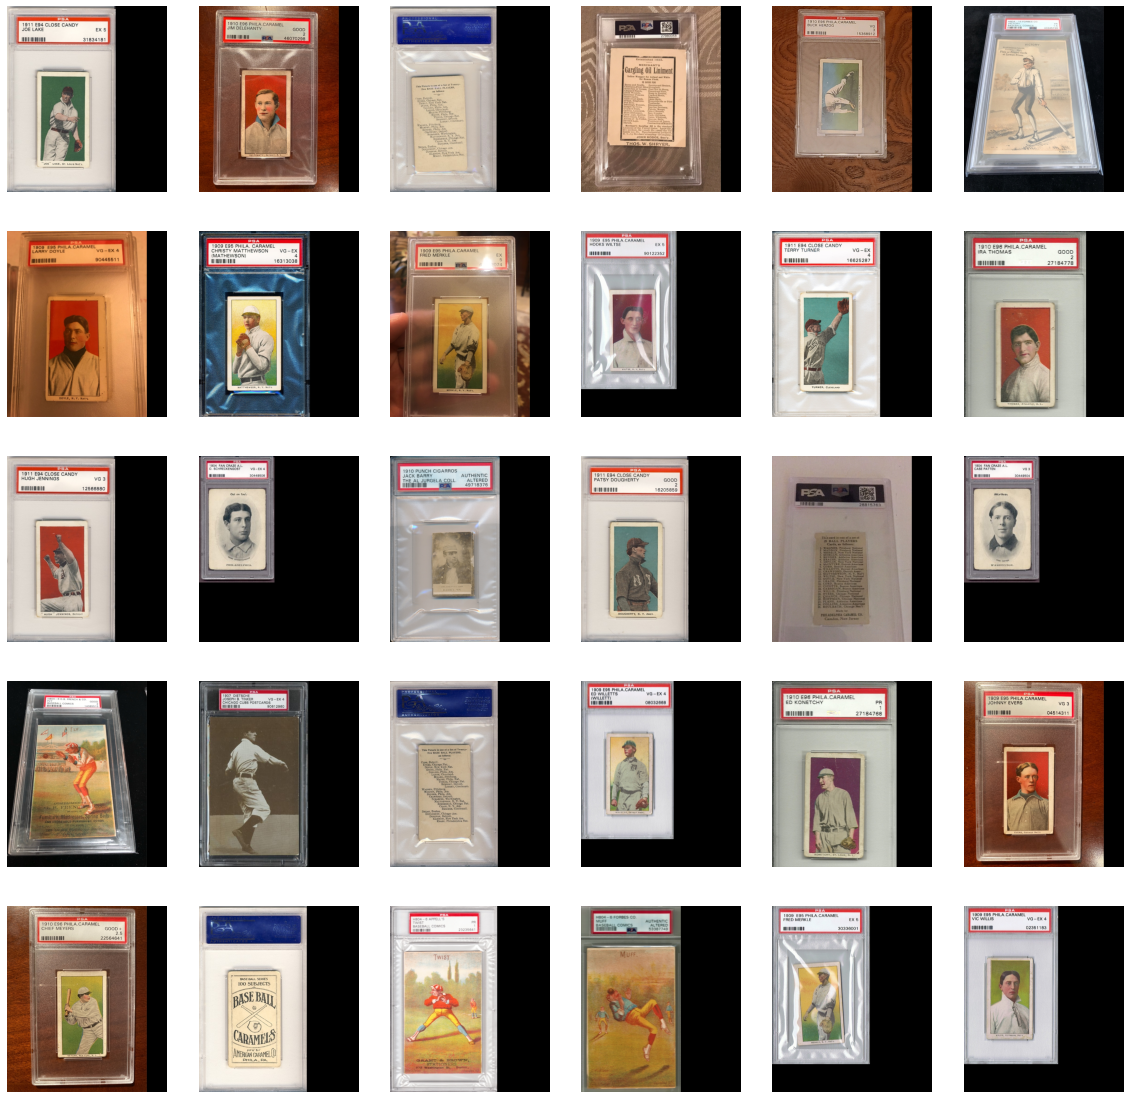

In [8]:
import numpy as np
import matplotlib.pyplot as plt

numb_cols = 6
numb_rows = 5

fix, axs = plt.subplots(numb_rows, numb_cols, figsize=(20,20))

def show(ax, card, title=None):
    ax.imshow(card)
    ax.axis('off')
    if title:
        ax.set_title(title)

i = 0
for j in range(numb_rows):
    for col in range(numb_cols):
        show(axs[j,col], cards[i])
        i += 1

plt.show()

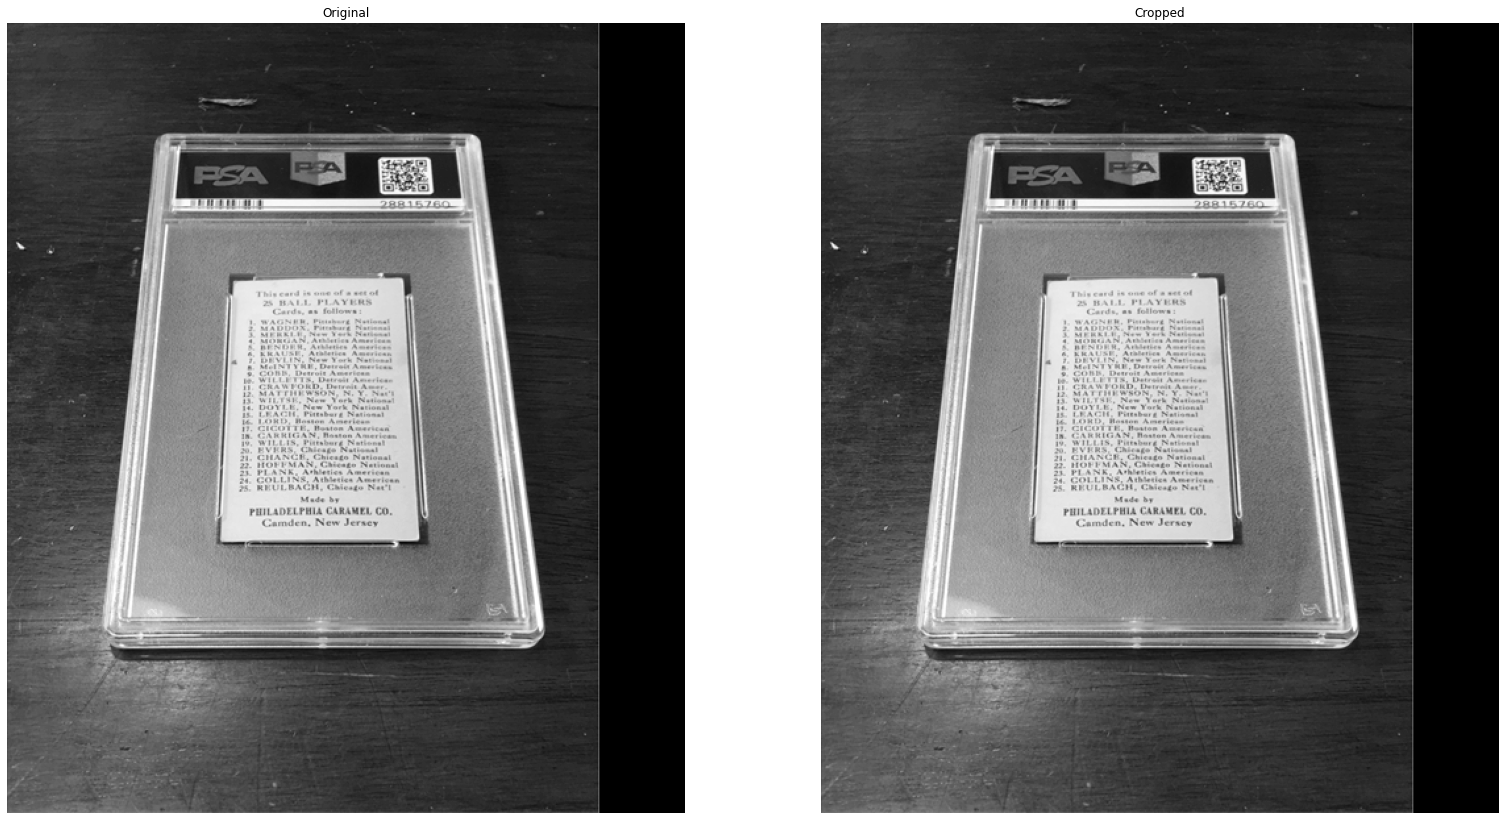

In [11]:
import numpy as np
import cv2
import tkinter as tk
from matplotlib.backends.backend_tkagg import (
    FigureCanvasTkAgg, NavigationToolbar2Tk)
from matplotlib.backend_bases import MouseButton, KeyEvent, MouseEvent
from matplotlib import pyplot as plt

root = tk.Tk()

fig, axs = plt.subplots(1, 2, figsize=(40,60))

canvas = FigureCanvasTkAgg(fig, master=root)  # A tk.DrawingArea.
canvas.draw()
canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

def _quit():
    root.quit()     # stops mainloop
    root.destroy()  # this is necessary on Windows to prevent
                    # Fatal Python Error: PyEval_RestoreThread: NULL tstate

button = tk.Button(master=root, text="Quit", command=_quit)
button.pack(side=tk.BOTTOM)

crop_labels = []

def label(cards):
    if len(cards) == 0:
        _quit()
    else:
        card, rest = cards[0], cards[1:]
        card_int8 = np.uint8(card)
        image = cv2.cvtColor(card_int8, cv2.COLOR_BGR2GRAY)

        ax = axs[0]
        ax.imshow(image, cmap='gray')
        ax.set_title('Original')
        ax.axis('off')

#        edges = cv2.Canny(image, 100, 450)
#        ax = axs[1]
#        ax.imshow(edges, cmap='gray')
#        ax.set_title('Edges')
#        ax.axis('off')

        ax = axs[1]
        ax.imshow(image, cmap='gray')
        ax.set_title('Cropped')
        ax.axis('off')

        top_left = None
        bottom_right = None

        def redraw():
            fig.canvas.draw()
            fig.canvas.flush_events()
            
        def reset(ax):
            nonlocal top_left
            nonlocal bottom_right
            
            top_left = None
            bottom_right = None
            
            while ax.lines:
                ax.lines.pop(0)            

        def onclick(event):
            nonlocal top_left
            nonlocal bottom_right
            
            global crop_labels
            
            if isinstance(event, MouseEvent):
                ix, iy, button = event.xdata, event.ydata, event.button
            elif isinstance(event, KeyEvent):
                button = event.key
                
            if button == MouseButton.LEFT:
                # print(ix, iy, button)
                point = (ix, iy)
                if not ix or not iy:
                    return
                if not top_left:
                    top_left = tuple(map(int, (ix, iy)))
                    axs[0].plot(ix, iy, color='red', marker='o')
                elif not bottom_right:
                    ratio = 600/400
                    
                    y1 = top_left[1] + (ix - top_left[0]) * ratio
                    bottom_right = tuple(map(int, (ix, y1)))

                    x0, y0 = top_left
                    x1, y1 = bottom_right

                    axs[0].plot((x0, x0), (y0, y1), color='red', marker = 'o')
                    axs[0].plot((x1, x1), (y0, y1), color='red', marker = 'o')
                    axs[0].plot((x0, x1), (y0, y0), color='red', marker = 'o')
                    axs[0].plot((x0, x1), (y1, y1), color='red', marker = 'o')
                    
                    cropped = image[y0:y1, x0:x1]

                    ax = axs[1]
                    ax.imshow(cropped, cmap='gray')
                    ax.set_title('Cropped')
                    ax.axis('off')

                redraw()
            elif button == MouseButton.RIGHT:
                reset(axs[0])
                redraw()
            elif button == 'enter' or button == ' ':
                if top_left and bottom_right:
                    for ax in axs:
                        ax.cla()
                    fig.canvas.mpl_disconnect(cid1)
                    fig.canvas.mpl_disconnect(cid2)

                    x0, y0 = top_left
                    x1, y1 = bottom_right

                    crop_labels.append((card,
                                        (x0, x1, y0, y1)))
                    
                    label(rest)
            elif button == 'escape':
                # Skip this sample
                for ax in axs:
                    ax.cla()
                fig.canvas.mpl_disconnect(cid1)
                fig.canvas.mpl_disconnect(cid2)

                label(rest)

        cid1 = fig.canvas.mpl_connect('button_press_event', onclick)
        cid2 = fig.canvas.mpl_connect('key_press_event', onclick)
        redraw()
        # plt.show()

label(cards)

tk.mainloop()

In [12]:
data = np.array([[*label[1], *label[0].flatten()] for label in crop_labels])

In [13]:
file_name = 'data/cropped_labels.out'
# np.savetxt(file_name, data)
# data = np.loadtxt(file_name)

In [15]:
RATIO = 2/3
N = data.shape[0]
splt = int(N * RATIO)
data_train = data[:splt]
data_test = data[splt:]

In [140]:
X_train = data_train[:, 4:]
y_train = data_train[:, :3]

In [141]:
X_test = data_test[:, 4:]
y_test = data_test[:, :3]

In [318]:
import numpy as np
from lib.layers.core import InputLayer, FullyConnectedLayer
from lib.layers.activation import ReluLayer
from lib.layers.objective import SquaredError
from lib.models import Model

def create_cropping_model(config):
    
    np.random.seed(0)
    
    learning_rate = config.get('learning_rate')
    scale = config.get('scale')
    
    layers = [
        InputLayer(X_train),
        
        FullyConnectedLayer(X_train.shape[1], 128, learning_rate=1e-2*learning_rate, scale=scale),
        ReluLayer(leaky=True),
        
        FullyConnectedLayer(128, 32, learning_rate=1e-1*learning_rate, scale=scale),
        ReluLayer(leaky=True),

        FullyConnectedLayer(32, 3, learning_rate=learning_rate, scale=scale),
        ReluLayer(leaky=True),
        
        SquaredError(),
    ]
    
    return Model(layers=layers)

In [321]:
config = {
    'learning_rate': 3e-4,
    'scale': 1e-4,
}
model = create_cropping_model(config)
losses = []

In [322]:
epochs = 2
for epoch in range(epochs):
    model.train(X_train, y_train, batch_size=30)
    N = X_train.shape[0]
    loss = model.loss(X_train, y_train)
    # print(loss)
    avg_loss = np.average(loss)
    losses.append(avg_loss)
    

In [323]:
losses

[42845.991107396076, 40771.14683497184]

In [324]:
model.eval(X_test)

array([[ 3.08246524, 14.0889966 ,  8.28799808],
       [ 3.08246591, 14.08899968,  8.28799971],
       [ 3.08246582, 14.08899926,  8.28799949],
       [ 3.08246584, 14.08899936,  8.28799954],
       [ 3.08246521, 14.08899643,  8.28799799],
       [ 3.08246603, 14.08900025,  8.28800001],
       [ 3.08246556, 14.0889981 ,  8.28799887],
       [ 3.08246575, 14.08899896,  8.28799933],
       [ 3.08246508, 14.08899583,  8.28799767],
       [ 3.08246512, 14.08899601,  8.28799776],
       [ 3.08246789, 14.08900889,  8.2880046 ],
       [ 3.08246631, 14.08900156,  8.28800071],
       [ 3.08246568, 14.08899862,  8.28799915],
       [ 3.08246542, 14.08899743,  8.28799852],
       [ 3.08246522, 14.08899649,  8.28799802],
       [ 3.08246594, 14.08899983,  8.28799979],
       [ 3.08246559, 14.08899819,  8.28799892],
       [ 3.0824654 , 14.08899733,  8.28799847],
       [ 3.08246608, 14.08900049,  8.28800014],
       [ 3.08246614, 14.08900079,  8.2880003 ],
       [ 3.08246548, 14.08899767,  8.287

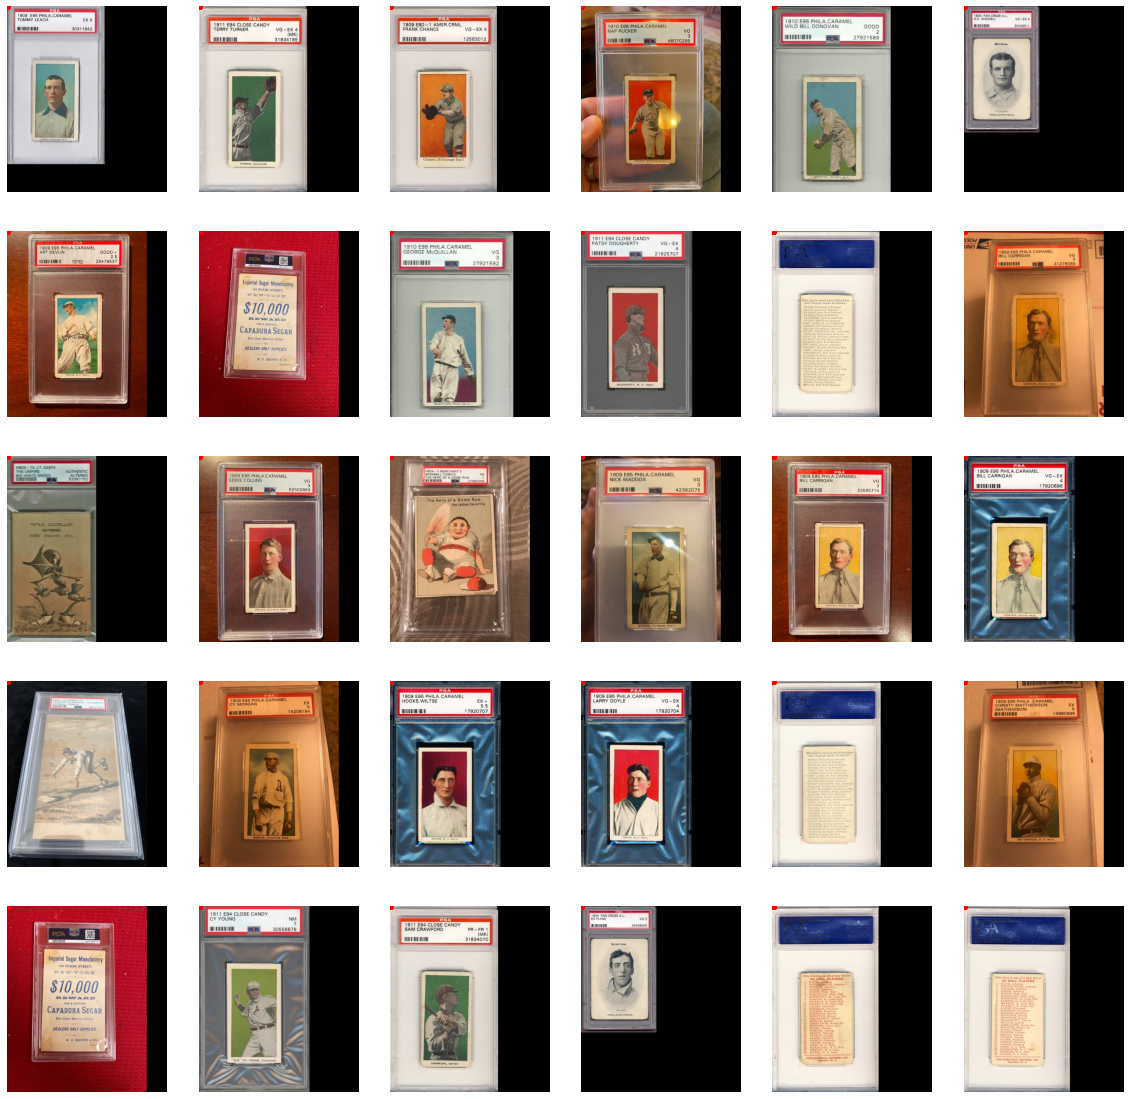

In [161]:
import numpy as np
import matplotlib.pyplot as plt

numb_cols = 6
numb_rows = 5

fix, axs = plt.subplots(numb_rows, numb_cols, figsize=(20,20))

def show(ax, card, bounds, title=None):
    ax.imshow(card.reshape((DIM[1], DIM[0], 3)))
    ax.axis('off')
    if title:
        ax.set_title(title)
        
    x0, x1, y0 = bounds
    
    ratio = 600/400
    y1 = y0 + ratio * (x1-x0)

    ax.plot((x0, x0), (y0, y1), color='red', marker = 'o')
    ax.plot((x1, x1), (y0, y1), color='red', marker = 'o')
    ax.plot((x0, x1), (y0, y0), color='red', marker = 'o')
    ax.plot((x0, x1), (y1, y1), color='red', marker = 'o')

y_pred = model.eval(X_test)
        
i = 0
for j in range(numb_rows):
    for col in range(numb_cols):
        show(axs[j,col], X_test[i], y_pred[i])
        i += 1

plt.show()

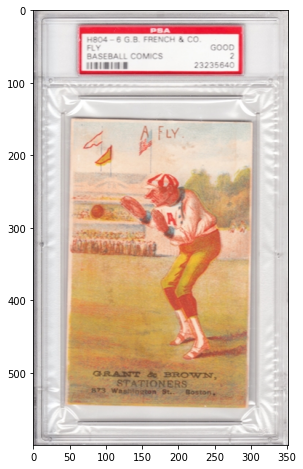

In [ ]:
from IPython.display import clear_output

is_card_labels = []

for card in cards[:100]:
    image = cv2.cvtColor(card.img, cv2.COLOR_BGR2RGB).astype(int)
    im = np.array(image)

    plt.figure(figsize=(12,8))
    plt.imshow(im)
    plt.show()
    inp = input()
    is_card_labels.append((int(inp), card))
    clear_output(wait=False)

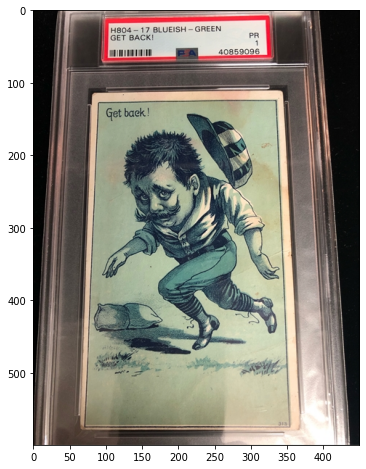

KeyboardInterrupt: Interrupted by user

In [96]:
from IPython.display import clear_output

is_front_labels = []

for card in cards[:100]:
    image = cv2.cvtColor(card.img, cv2.COLOR_BGR2RGB).astype(int)
    im = np.array(image)

    plt.figure(figsize=(12,8))
    plt.imshow(im)
    plt.show()
    inp = input()
    is_front_labels.append((int(inp), card))
    clear_output(wait=False)

In [91]:
len(is_card_labels)

10